#### Libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import itertools

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
import warnings
warnings.filterwarnings("ignore")

#### Data

In [3]:
tx = pd.read_csv("merged-df.csv")                       # transactions
users = pd.read_csv("final_features_with_clusters.csv") # user-level with Cluster

print("tx shape:", tx.shape)
print("users shape:", users.shape)
print("tx columns:", tx.columns)
print("users columns:", users.columns)

tx shape: (13305915, 36)
users shape: (1219, 33)
tx columns: Index(['transaction_id', 'date', 'user_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'description', 'category', 'user_current_age', 'user_retirement_age',
       'user_birth_year', 'user_birth_month', 'user_gender', 'user_address',
       'user_latitude', 'user_longitude', 'user_per_capita_income',
       'user_yearly_income', 'user_total_debt', 'user_credit_score',
       'user_num_credit_cards', 'card_card_brand', 'card_card_type',
       'card_has_chip', 'card_cvv', 'card_expires', 'card_num_cards_issued',
       'card_credit_limit', 'card_acct_open_date',
       'card_year_pin_last_changed', 'card_card_on_dark_web'],
      dtype='object')
users columns: Index(['user_id', 'total_txn_count', 'total_amount', 'avg_amount',
       'std_amount', 'median_amount', 'first_txn', 'last_txn', 'user_gender',
       'user_current_age', 'user_birth_year', 'user_yearly

In [4]:
tx['date'] = pd.to_datetime(tx['date'], errors='coerce')
print("tx date range:", tx['date'].min(), "→", tx['date'].max())

tx date range: 2010-01-01 00:01:00 → 2019-10-31 23:59:00


#### Final df with clusters

In [5]:
cluster_map = users[['user_id', 'Cluster']].drop_duplicates()
df = tx.merge(cluster_map, on='user_id', how='left')

In [6]:
df

,transaction_id,date,user_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,card_card_type,card_has_chip,card_cvv,card_expires,card_num_cards_issued,card_credit_limit,card_acct_open_date,card_year_pin_last_changed,card_card_on_dark_web,Cluster
0,7475327,2010-01-01 00:01:00,1556,2972,-77.0000,Swipe Transaction,59935,Beulah,ND,58523,...,Debit (Prepaid),YES,306,2022-07-01,2,55.0000,2008-05-01,2008,No,3
1,7475328,2010-01-01 00:02:00,561,4575,14.5700,Swipe Transaction,67570,Bettendorf,IA,52722,...,Credit,YES,438,2024-12-01,1,"9,100.0000",2005-09-01,2015,No,3
2,7475329,2010-01-01 00:02:00,1129,102,80.0000,Swipe Transaction,27092,Vista,CA,92084,...,Debit,YES,256,2020-05-01,1,"14,802.0000",2006-01-01,2008,No,2
3,7475331,2010-01-01 00:05:00,430,2860,200.0000,Swipe Transaction,27092,Crown Point,IN,46307,...,Debit,NO,54,2024-10-01,2,"37,634.0000",2004-05-01,2006,No,0
4,7475332,2010-01-01 00:06:00,848,3915,46.4100,Swipe Transaction,13051,Harwood,MD,20776,...,Debit,YES,120,2020-01-01,1,"19,113.0000",2009-07-01,2014,No,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,2019-10-31 23:56:00,1718,2379,1.1100,Chip Transaction,86438,West Covina,CA,91792,...,Debit,YES,992,2020-02-01,1,"26,743.0000",2019-03-01,2019,No,0
13305911,23761869,2019-10-31 23:56:00,1766,2066,12.8000,Online Transaction,39261,ONLINE,Unknown,Unknown,...,Debit,YES,91,2024-06-01,1,"5,141.0000",2004-03-01,2012,No,1
13305912,23761870,2019-10-31 23:57:00,199,1031,40.4400,Swipe Transaction,2925,Allen,TX,75002,...,Debit,YES,908,2021-06-01,1,"17,686.0000",2004-02-01,2007,No,1
13305913,23761873,2019-10-31 23:58:00,1986,5443,4.0000,Chip Transaction,46284,Daly City,CA,94014,...,Debit,YES,762,2021-11-01,2,"14,036.0000",2005-11-01,2010,No,1


#### exclude refunds (negative amounts)

In [7]:
before = len(df)
df = df[df['amount'] > 0].copy()
after = len(df)
print(f"Removed refunds: {before-after:,} rows ({100*(before-after)/before:.2f}%)")

Removed refunds: 670,688 rows (5.04%)


#### Aggregate to Cluster × Month (target series)

In [50]:
cluster_monthly = (
    df.groupby(['Cluster', pd.Grouper(key='date', freq='M')])['amount']
      .sum()
      .reset_index()
      .rename(columns={'amount':'total_amount'})
      .sort_values(['Cluster','date'])
)
cluster_monthly.tail()

,Cluster,date,total_amount
467,3,2019-06-30,"1,033,032.6900"
468,3,2019-07-31,"1,061,661.1600"
469,3,2019-08-31,"1,061,982.1400"
470,3,2019-09-30,"1,036,589.8500"
471,3,2019-10-31,"1,070,379.6700"


In [9]:
# 0) Make sure your 'date' is month-end aligned and datetime
cluster_monthly = cluster_monthly.copy()
cluster_monthly['date'] = pd.to_datetime(cluster_monthly['date']).dt.to_period('M').dt.to_timestamp('M')

# 1) Compute expected vs actual months per cluster correctly
def expected_months_count(start_ts, end_ts):
    return len(pd.period_range(start=start_ts, end=end_ts, freq='M'))  # inclusive count

ranges = (
    cluster_monthly.groupby('Cluster')['date']
    .agg(start='min', end='max')
    .reset_index()
)
ranges['expected_months'] = ranges.apply(lambda r: expected_months_count(r['start'], r['end']), axis=1)
actual = cluster_monthly.groupby('Cluster')['date'].nunique().reset_index(name='actual_months')
check = ranges.merge(actual, on='Cluster', how='left')
check['missing_months'] = check['expected_months'] - check['actual_months']
print(check)

   Cluster      start        end  expected_months  actual_months  \
0        0 2010-01-31 2019-10-31              118            118   
1        1 2010-01-31 2019-10-31              118            118   
2        2 2010-01-31 2019-10-31              118            118   
3        3 2010-01-31 2019-10-31              118            118   

   missing_months  
0               0  
1               0  
2               0  
3               0  


### No missing months in df

#### Quick EDA of composition

In [10]:
# Users' first/last txn and tenure (overview)
user_lifetimes = (
    df.groupby('user_id')['date']
      .agg(first_txn='min', last_txn='max')
      .reset_index()
)
user_lifetimes['tenure_days'] = (user_lifetimes['last_txn'] - user_lifetimes['first_txn']).dt.days
print(user_lifetimes['tenure_days'].describe())

count   1,219.0000
mean    3,491.8261
std       361.3576
min       852.0000
25%     3,589.0000
50%     3,590.0000
75%     3,590.0000
max     3,590.0000
Name: tenure_days, dtype: float64


- Most users were active through the full time range
- min = 852 --> A few joined late (maybe around 2017)

### Exploratory Analysis

#### 1. Total Spending Variation per Cluster

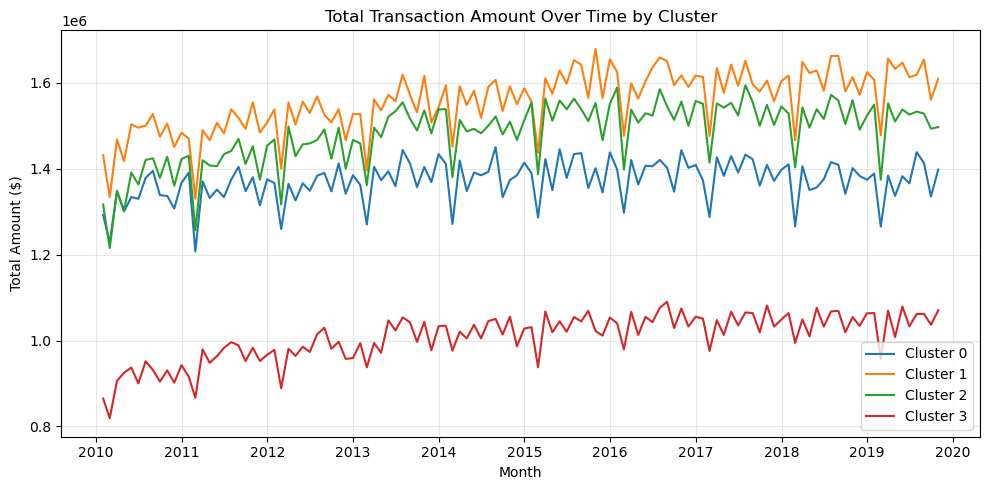

In [11]:
plt.figure(figsize=(10,5))

for c in cluster_monthly['Cluster'].unique():
    sub = cluster_monthly[cluster_monthly['Cluster']==c]
    plt.plot(sub['date'], sub['total_amount'], label=f'Cluster {c}')

plt.title('Total Transaction Amount Over Time by Cluster')
plt.xlabel('Month')
plt.ylabel('Total Amount ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

- exhibits seasonality
- clusters are separated by spending totals

#### 2. Rolling Mean & Variance per Cluster

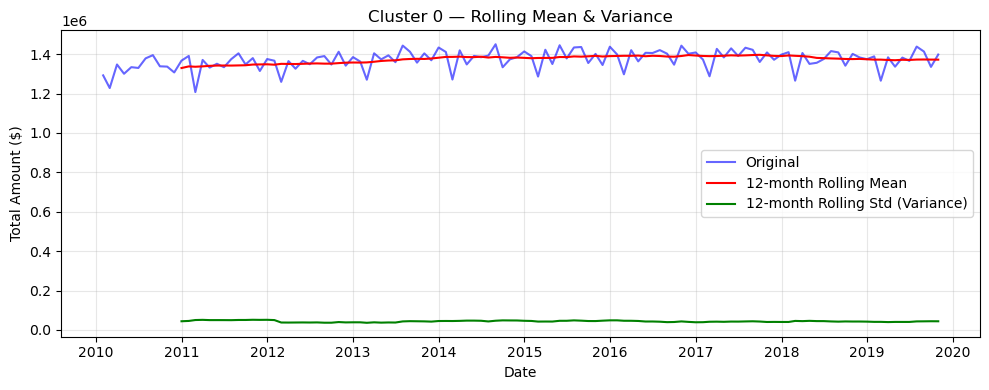

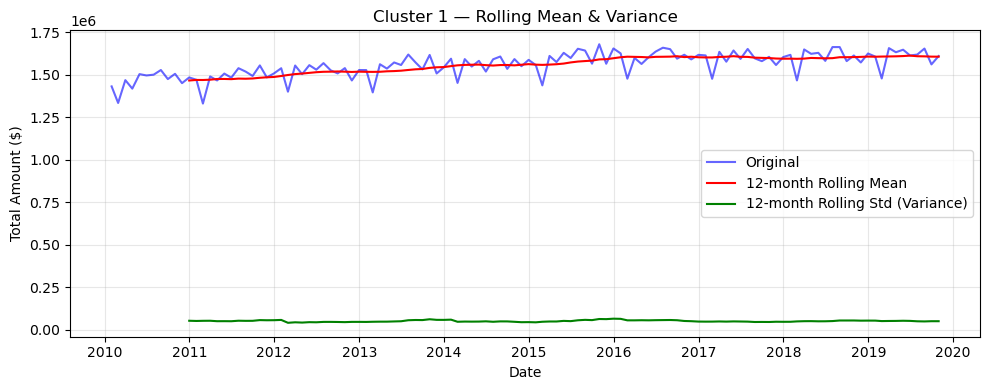

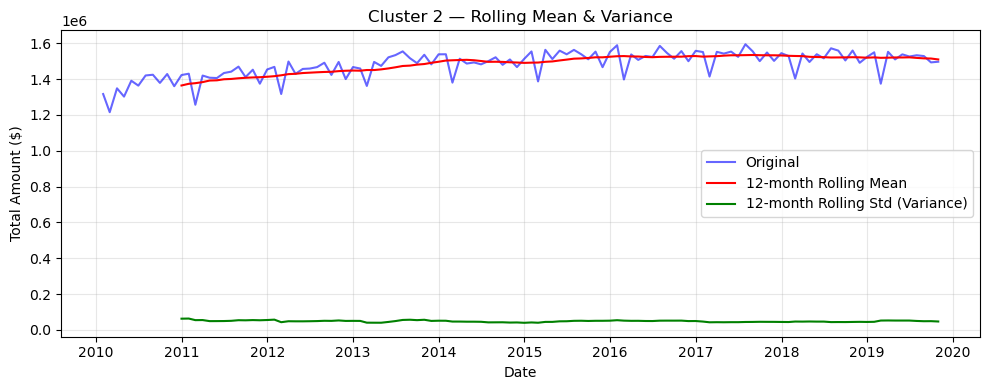

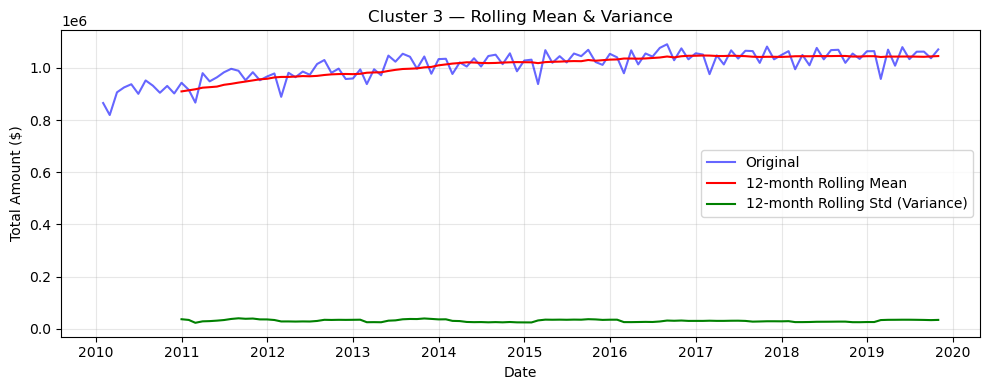

In [12]:
window = 12  # 12-month rolling window
for c in sorted(cluster_monthly['Cluster'].unique()):
    sub = cluster_monthly[cluster_monthly['Cluster']==c].set_index('date')['total_amount']
    rol_mean = sub.rolling(window).mean()
    rol_std  = sub.rolling(window).std()

    plt.figure(figsize=(10,4))
    plt.plot(sub, label='Original', color='blue', alpha=0.6)
    plt.plot(rol_mean, label=f'{window}-month Rolling Mean', color='red')
    plt.plot(rol_std, label=f'{window}-month Rolling Std (Variance)', color='green')
    plt.title(f'Cluster {c} — Rolling Mean & Variance')
    plt.xlabel('Date'); plt.ylabel('Total Amount ($)')
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

#### 3. Seasonal-Trend Decomposition (STL)

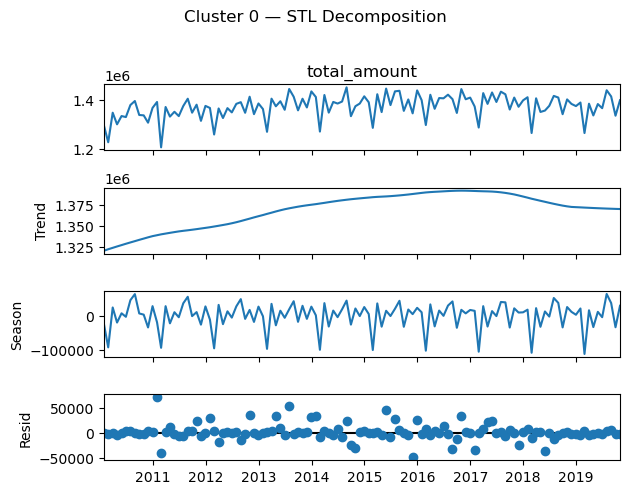

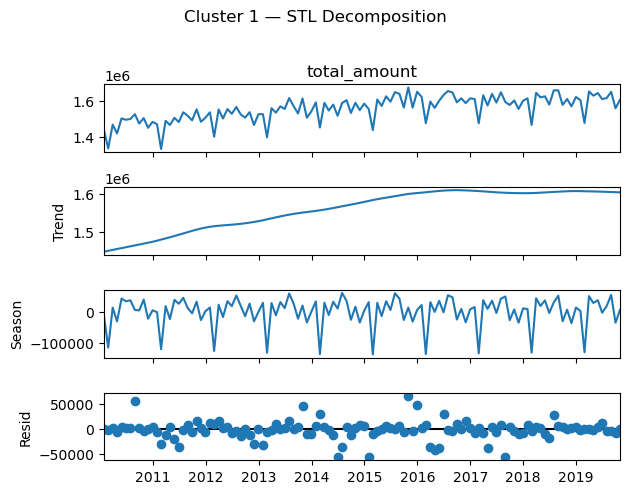

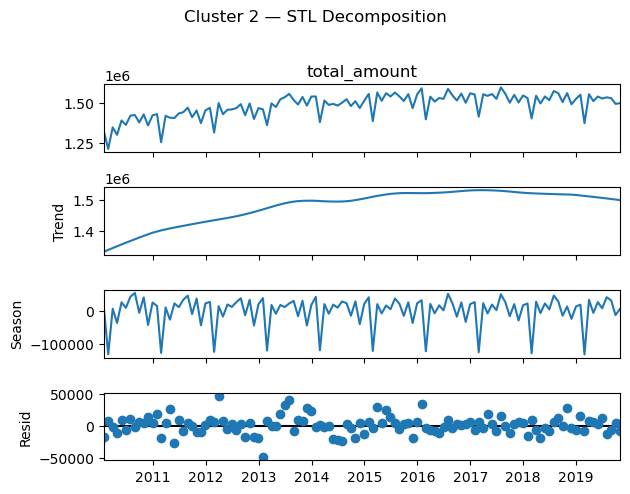

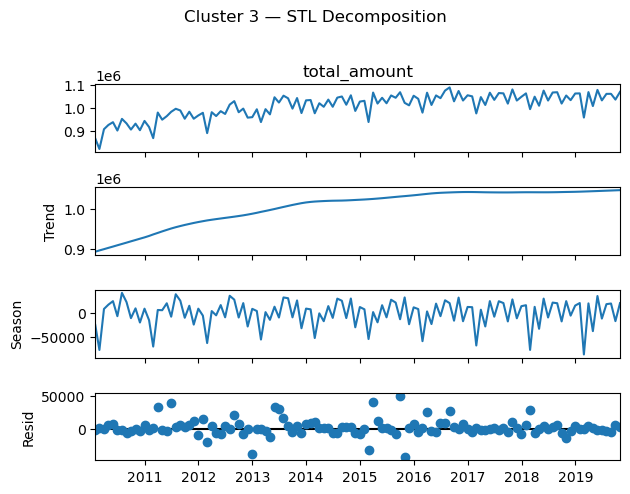

In [13]:
for c in sorted(cluster_monthly['Cluster'].unique()):
    sub = cluster_monthly[cluster_monthly['Cluster']==c].set_index('date')['total_amount']
    sub = sub.asfreq('ME')  # ensure regular frequency
    stl = STL(sub, period=12, robust=True)
    res = stl.fit()
    res.plot()
    plt.suptitle(f'Cluster {c} — STL Decomposition', y=1.02)
    plt.tight_layout(); plt.show()

1. **Trend:** slow, upward trend across all clusters
2. **Seasonality:** strong, repeating 12-month pattern in every cluster
3. **Residuals:** randomly scattered

### Stationarity Check + Differencing (d)

### Formal test for stationarity using ADF and KPSS

1. ADF:

Null: Non-stationary

We need a small p-value (< 0.05) to reject it.

2. KPSS

Null: Stationary

We need a large p-value (> 0.05) to confirm stationarity.

In [14]:
def test_stationarity(ts, name='Series'):
    print(f'\nStationarity tests for {name}')
    
    # ADF Test
    adf_res = adfuller(ts.dropna())
    print(f"ADF Statistic: {adf_res[0]:.3f}")
    print(f"p-value: {adf_res[1]:.3f}")
    print("=> Non-stationary" if adf_res[1] > 0.05 else "=> Stationary")
    
    # KPSS Test
    kpss_res = kpss(ts.dropna(), regression='c', nlags='auto')
    print(f"\nKPSS Statistic: {kpss_res[0]:.3f}")
    print(f"p-value: {kpss_res[1]:.3f}")
    print("=> Stationary" if kpss_res[1] > 0.05 else "=> Non-stationary")

for cluster_id in sorted(cluster_monthly['Cluster'].unique()):
    ts = (
        cluster_monthly[cluster_monthly['Cluster'] == cluster_id]
        .set_index('date')['total_amount']
    )
    test_stationarity(ts, f'Cluster {cluster_id} - Original Series')


Stationarity tests for Cluster 0 - Original Series
ADF Statistic: -2.795
p-value: 0.059
=> Non-stationary

KPSS Statistic: 1.152
p-value: 0.010
=> Non-stationary

Stationarity tests for Cluster 1 - Original Series
ADF Statistic: -2.101
p-value: 0.244
=> Non-stationary

KPSS Statistic: 1.730
p-value: 0.010
=> Non-stationary

Stationarity tests for Cluster 2 - Original Series
ADF Statistic: -2.572
p-value: 0.099
=> Non-stationary

KPSS Statistic: 1.553
p-value: 0.010
=> Non-stationary

Stationarity tests for Cluster 3 - Original Series
ADF Statistic: -5.659
p-value: 0.000
=> Stationary

KPSS Statistic: 1.709
p-value: 0.010
=> Non-stationary


All are non-stationary. 

In [16]:
for cluster_id in sorted(cluster_monthly['Cluster'].unique()):
    ts = (
        cluster_monthly[cluster_monthly['Cluster']==cluster_id]
        .set_index('date')['total_amount']
        .asfreq('ME')
    )
    ts_diff = ts.diff().dropna()
    test_stationarity(ts_diff, f'Cluster {cluster_id} - After 1st Differencing')


Stationarity tests for Cluster 0 - After 1st Differencing
ADF Statistic: -12.684
p-value: 0.000
=> Stationary

KPSS Statistic: 0.163
p-value: 0.100
=> Stationary

Stationarity tests for Cluster 1 - After 1st Differencing
ADF Statistic: -3.244
p-value: 0.018
=> Stationary

KPSS Statistic: 0.173
p-value: 0.100
=> Stationary

Stationarity tests for Cluster 2 - After 1st Differencing
ADF Statistic: -2.651
p-value: 0.083
=> Non-stationary

KPSS Statistic: 0.352
p-value: 0.098
=> Stationary

Stationarity tests for Cluster 3 - After 1st Differencing
ADF Statistic: -3.269
p-value: 0.016
=> Stationary

KPSS Statistic: 0.092
p-value: 0.100
=> Stationary


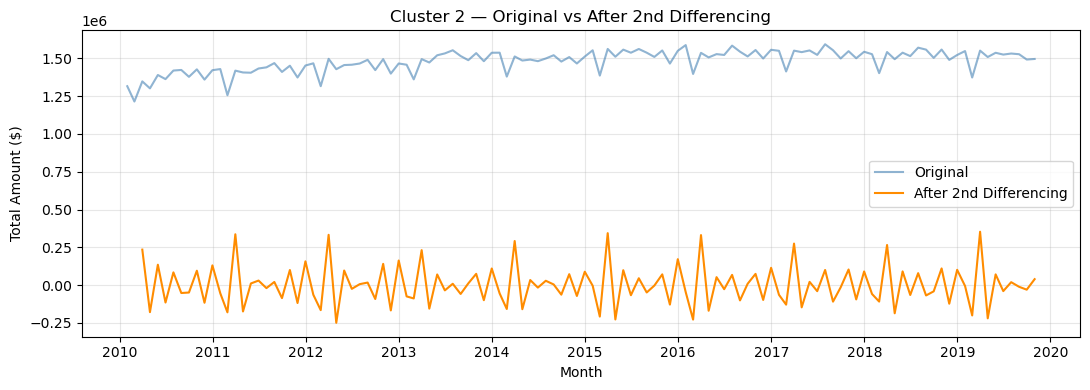

In [15]:
cid = 2
ts2 = (
    cluster_monthly[cluster_monthly['Cluster'] == cid]
    .set_index('date')['total_amount']
    .asfreq('ME')
)
ts2_d2 = ts2.diff().diff().dropna()
plt.figure(figsize=(11,4))
plt.plot(ts2, label='Original', color='steelblue', alpha=0.6)
plt.plot(ts2_d2, label='After 2nd Differencing', color='darkorange')
plt.title(f'Cluster {cid} — Original vs After 2nd Differencing')
plt.xlabel('Month'); plt.ylabel('Total Amount ($)')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

In [16]:
test_stationarity(ts2_d2, f'Cluster {cid} - After 2nd Differencing')


Stationarity tests for Cluster 2 - After 2nd Differencing
ADF Statistic: -10.929
p-value: 0.000
=> Stationary

KPSS Statistic: 0.311
p-value: 0.100
=> Stationary


### ACF and PACF (p, q)

In [21]:
def test_stationarity(ts, name='Series'):
    print(f'\nStationarity tests for {name}')
    adf_res = adfuller(ts.dropna())
    print(f"ADF Statistic: {adf_res[0]:.3f}")
    print(f"p-value: {adf_res[1]:.3f}")
    print("=> Non-stationary" if adf_res[1] > 0.05 else "=> Stationary")
    kpss_res = kpss(ts.dropna(), regression='c', nlags='auto')
    print(f"\nKPSS Statistic: {kpss_res[0]:.3f}")
    print(f"p-value: {kpss_res[1]:.3f}")
    print("=> Stationary" if kpss_res[1] > 0.05 else "=> Non-stationary")

In [22]:
def plot_acf_pacf(series, title, lags=36):
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    plot_acf(series.dropna(), lags=lags, ax=axes[0])
    axes[0].set_title('Autocorrelation')
    plot_pacf(series.dropna(), lags=lags, ax=axes[1], method='ywm')
    axes[1].set_title('Partial Autocorrelation')
    fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()

In [23]:
SEASONAL_LAG = 12


Stationarity tests for Cluster 0 - Original Series
ADF Statistic: -2.795
p-value: 0.059
=> Non-stationary

KPSS Statistic: 1.152
p-value: 0.010
=> Non-stationary


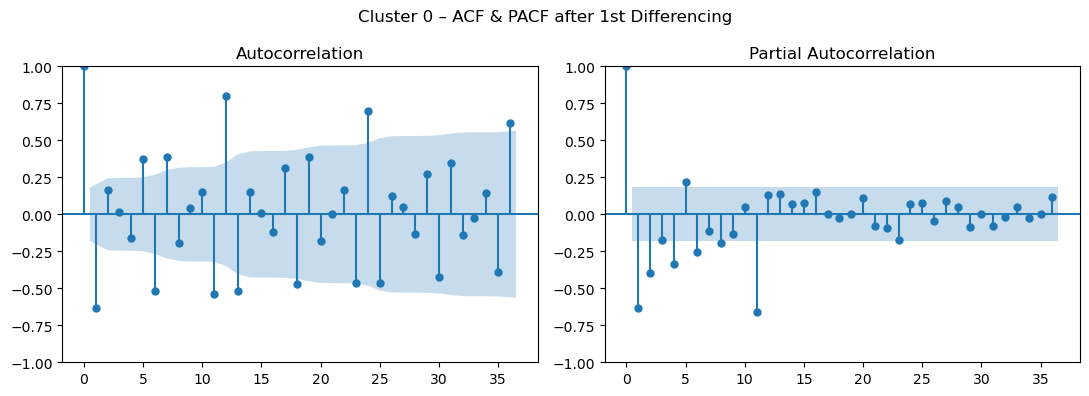

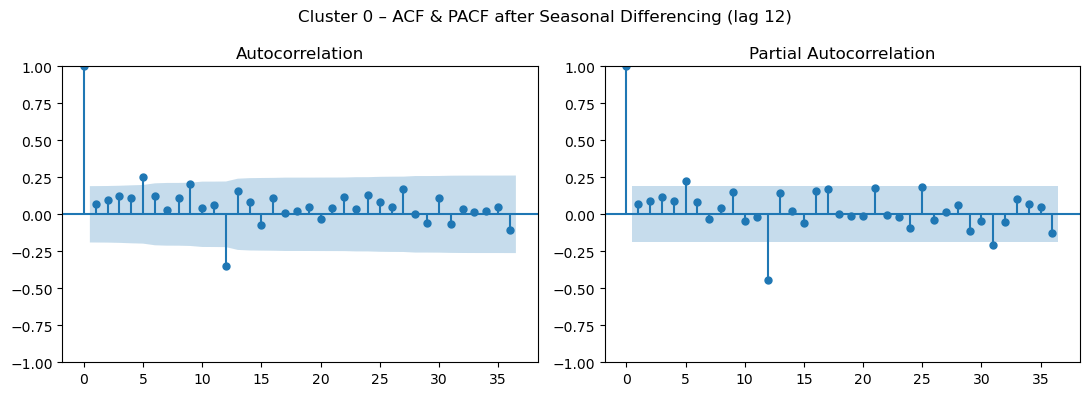


Stationarity tests for Cluster 1 - Original Series
ADF Statistic: -2.101
p-value: 0.244
=> Non-stationary

KPSS Statistic: 1.730
p-value: 0.010
=> Non-stationary


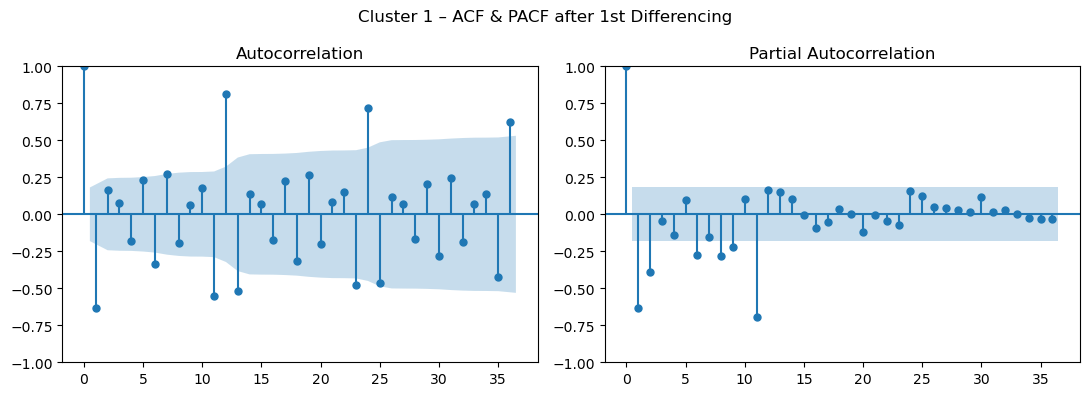

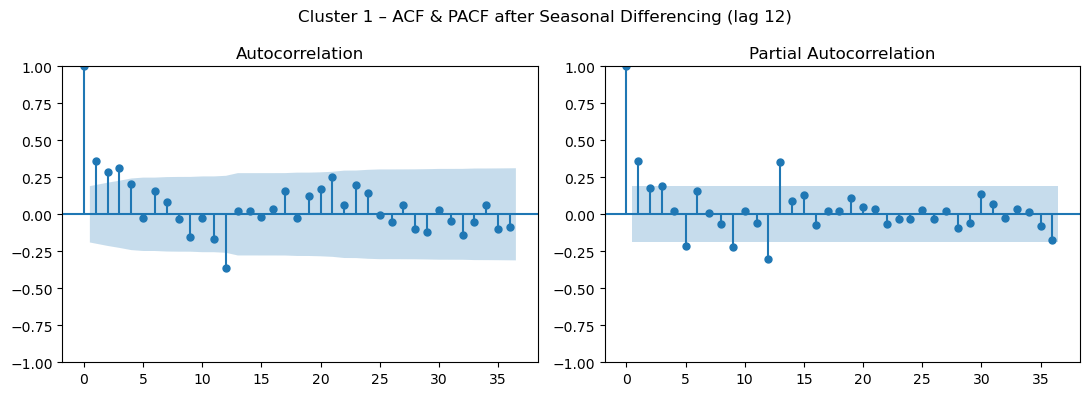


Stationarity tests for Cluster 2 - Original Series
ADF Statistic: -2.572
p-value: 0.099
=> Non-stationary

KPSS Statistic: 1.553
p-value: 0.010
=> Non-stationary


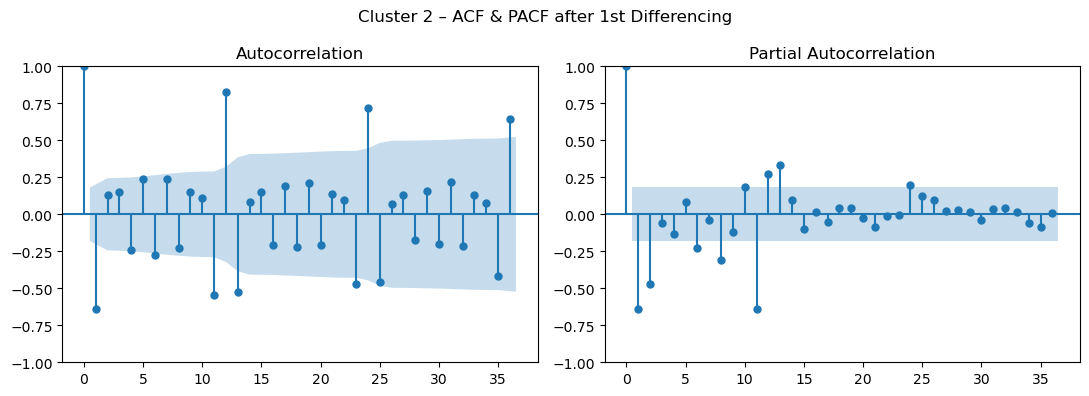

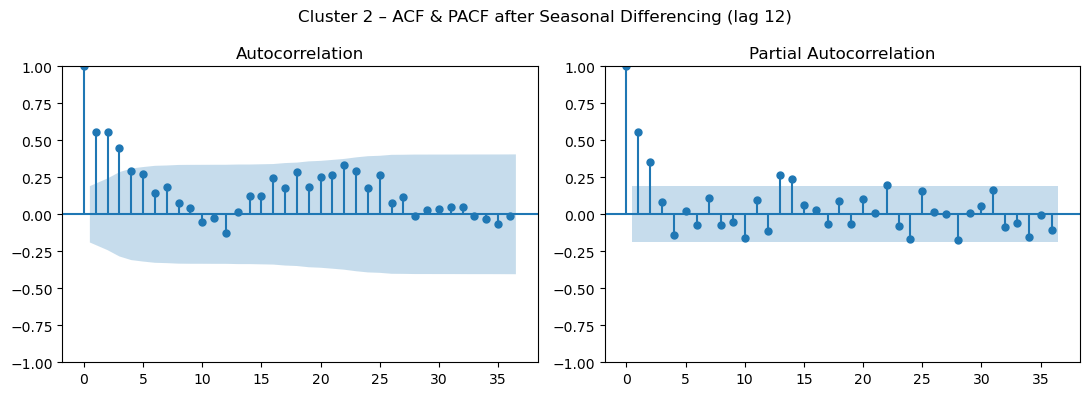


Stationarity tests for Cluster 3 - Original Series
ADF Statistic: -5.659
p-value: 0.000
=> Stationary

KPSS Statistic: 1.709
p-value: 0.010
=> Non-stationary


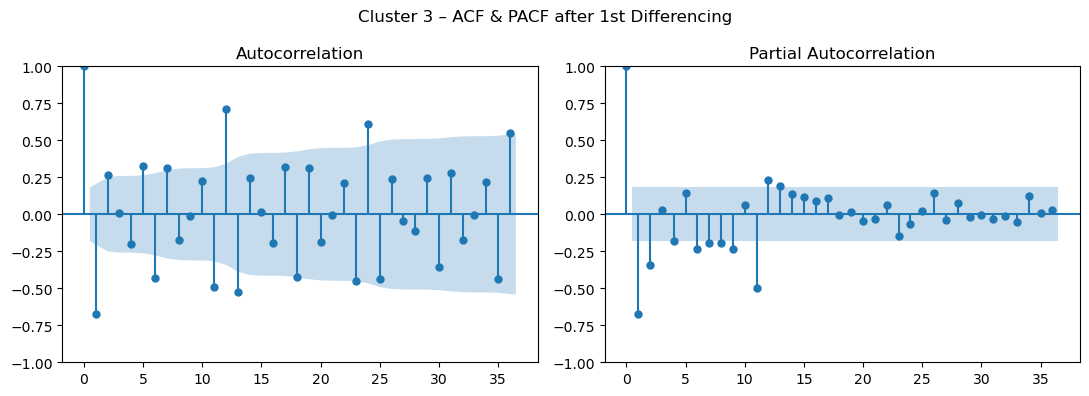

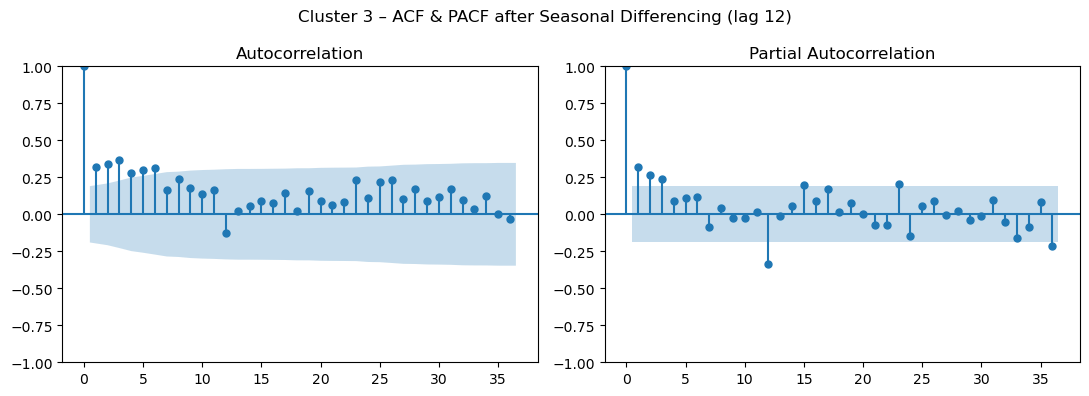

In [24]:
for cluster_id in sorted(cluster_monthly['Cluster'].unique()):
    # 1) get monthly series with strict freq
    ts = (
        cluster_monthly[cluster_monthly['Cluster'] == cluster_id]
        .set_index('date')['total_amount']
        .asfreq('ME')
        .fillna(0.0)  # reasonable for spend gaps
    )

    # 2) stationarity on original
    test_stationarity(ts, f'Cluster {cluster_id} - Original Series')

    # 3) ACF/PACF after 1st difference (short-memory structure)
    ts_diff = ts.diff().dropna()
    plot_acf_pacf(ts_diff, f'Cluster {cluster_id} – ACF & PACF after 1st Differencing', lags=36)

    # 4) ACF/PACF after seasonal difference (lag=12) (seasonal structure)
    ts_seasonal_diff = ts.diff(SEASONAL_LAG).dropna()
    plot_acf_pacf(ts_seasonal_diff, f'Cluster {cluster_id} – ACF & PACF after Seasonal Differencing (lag {SEASONAL_LAG})', lags=36)

In [25]:
from statsmodels.tsa.stattools import adfuller, kpss

def _adf_kpss_flags(x, alpha=0.05):
    x = pd.Series(x).dropna()
    if len(x) < 15:  # too short for reliable tests
        return dict(adf_stat=np.nan, adf_p=np.nan, adf_stationary=False,
                    kpss_stat=np.nan, kpss_p=np.nan, kpss_stationary=False)
    # flat series guard
    if np.nanstd(x) == 0:
        return dict(adf_stat=np.nan, adf_p=np.nan, adf_stationary=True,
                    kpss_stat=np.nan, kpss_p=1.0, kpss_stationary=True)
    # ADF: H0 = unit root (non-stationary) -> p<alpha means stationary
    adf_stat, adf_p, *_ = adfuller(x, autolag='AIC')
    # KPSS: H0 = stationary -> p>alpha means stationary
    try:
        kpss_stat, kpss_p, *_ = kpss(x, regression='c', nlags='auto')
    except Exception:
        # rare numerical issues; treat as non-stationary
        kpss_stat, kpss_p = np.nan, 0.0
    return dict(
        adf_stat=adf_stat, adf_p=adf_p, adf_stationary=(adf_p < alpha),
        kpss_stat=kpss_stat, kpss_p=kpss_p, kpss_stationary=(kpss_p > alpha)
    )

def choose_d(ts, max_d=2, alpha=0.05, verbose=False):
    """
    Returns (d, ts_diffed, diagnostics_dict) where ts_diffed is ts differenced d times.
    Chooses smallest d in [0..max_d] such that ADF and KPSS both say stationary.
    """
    ts = ts.asfreq('ME')  # ensure monthly freq
    cur = ts.copy()
    for d in range(0, max_d+1):
        diag = _adf_kpss_flags(cur.dropna(), alpha=alpha)
        if verbose:
            print(f"d={d} | ADF p={diag['adf_p']:.3f} "
                  f"| KPSS p={diag['kpss_p']:.3f} "
                  f"| ADF_stat={diag['adf_stat']:.3f} | KPSS_stat={diag['kpss_stat']:.3f}")
        if diag['adf_stationary'] and diag['kpss_stationary']:
            return d, cur.dropna(), diag
        # prepare next difference if needed
        cur = cur.diff()
    # if nothing passed, return the max differenced series
    return max_d, cur.dropna(), diag

# ------- Run across clusters & summarize -------
summary_rows = []
for cid in sorted(cluster_monthly['Cluster'].unique()):
    ts = (cluster_monthly[cluster_monthly['Cluster']==cid]
          .set_index('date')['total_amount']
          .asfreq('ME').fillna(0.0))
    d, ts_d, diag = choose_d(ts, max_d=2, alpha=0.05, verbose=True)
    summary_rows.append({
        "Cluster": cid,
        "Chosen_d": d,
        "ADF_p_after_d": round(diag['adf_p'], 4) if diag['adf_p']==diag['adf_p'] else np.nan,
        "KPSS_p_after_d": round(diag['kpss_p'], 4) if diag['kpss_p']==diag['kpss_p'] else np.nan,
        "Series_len_after_d": len(ts_d)
    })
    print(f"→ Cluster {cid}: choose d={d}")

d_summary = pd.DataFrame(summary_rows).sort_values("Cluster")
print("\nNon-seasonal differencing summary (target for ARIMA d):")
print(d_summary.to_string(index=False))

d=0 | ADF p=0.059 | KPSS p=0.010 | ADF_stat=-2.795 | KPSS_stat=1.152
d=1 | ADF p=0.000 | KPSS p=0.100 | ADF_stat=-12.684 | KPSS_stat=0.163
→ Cluster 0: choose d=1
d=0 | ADF p=0.244 | KPSS p=0.010 | ADF_stat=-2.101 | KPSS_stat=1.730
d=1 | ADF p=0.018 | KPSS p=0.100 | ADF_stat=-3.244 | KPSS_stat=0.173
→ Cluster 1: choose d=1
d=0 | ADF p=0.099 | KPSS p=0.010 | ADF_stat=-2.572 | KPSS_stat=1.553
d=1 | ADF p=0.083 | KPSS p=0.098 | ADF_stat=-2.651 | KPSS_stat=0.352
d=2 | ADF p=0.000 | KPSS p=0.100 | ADF_stat=-10.929 | KPSS_stat=0.311
→ Cluster 2: choose d=2
d=0 | ADF p=0.000 | KPSS p=0.010 | ADF_stat=-5.659 | KPSS_stat=1.709
d=1 | ADF p=0.016 | KPSS p=0.100 | ADF_stat=-3.269 | KPSS_stat=0.092
→ Cluster 3: choose d=1

Non-seasonal differencing summary (target for ARIMA d):
 Cluster  Chosen_d  ADF_p_after_d  KPSS_p_after_d  Series_len_after_d
       0         1         0.0000          0.1000                 117
       1         1         0.0176          0.1000                 117
       2      

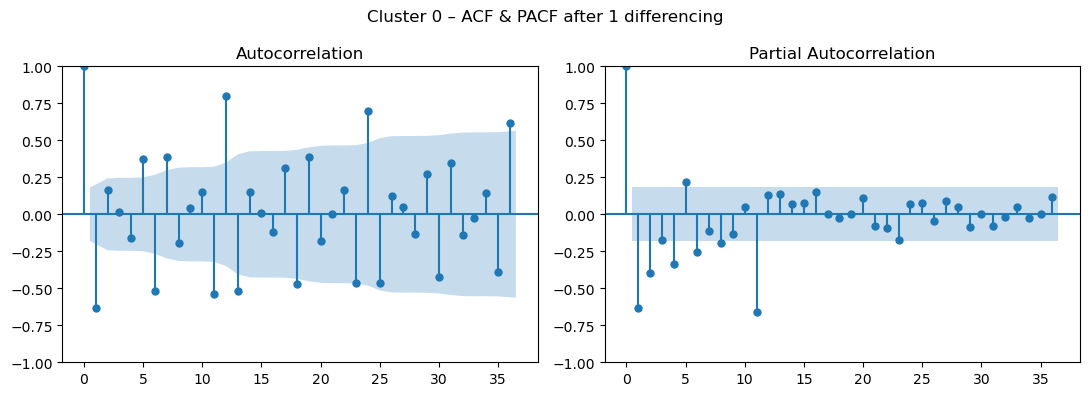

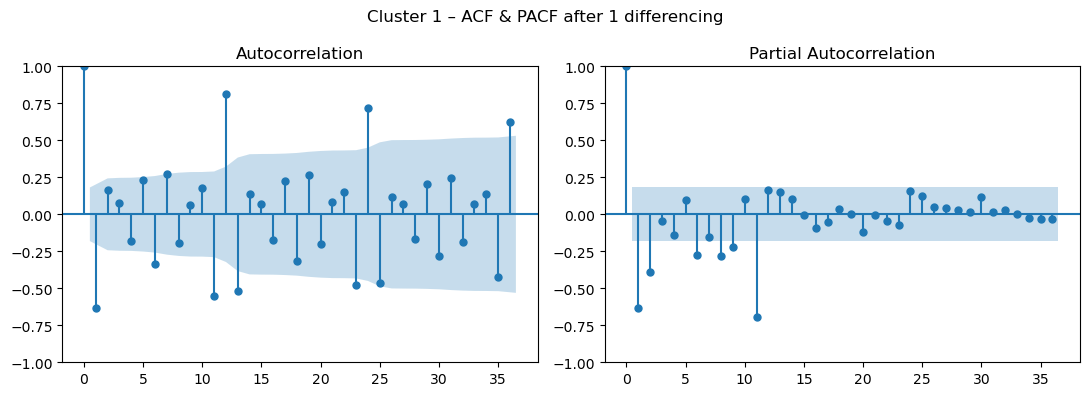

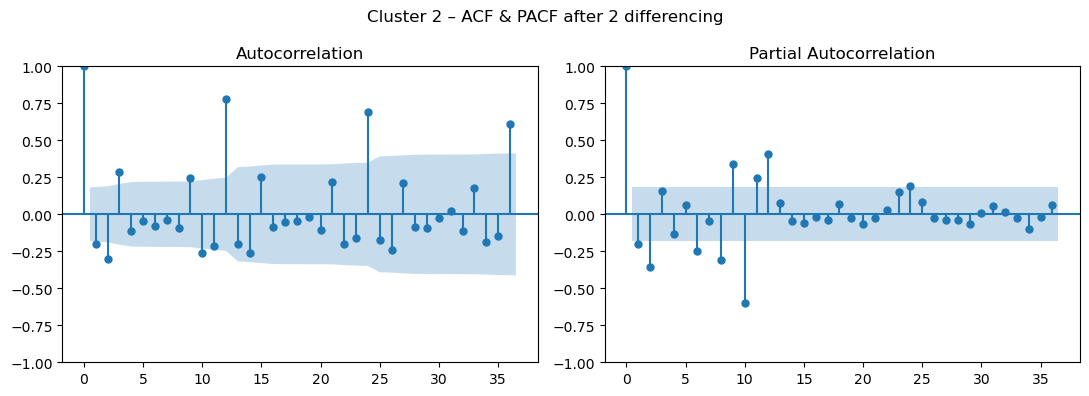

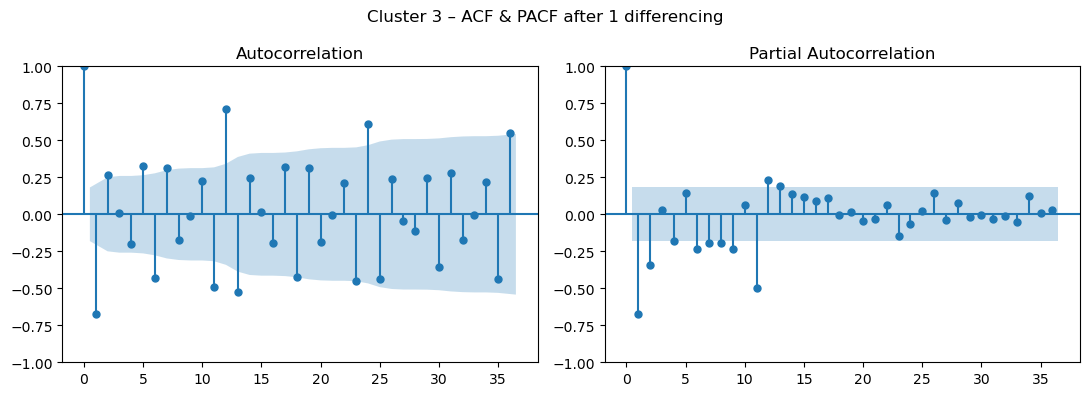

In [26]:
chosen_d_map = {0:1, 1:1, 2:2, 3:1}

for cid in sorted(cluster_monthly['Cluster'].unique()):
    ts = (cluster_monthly[cluster_monthly['Cluster']==cid]
          .set_index('date')['total_amount']
          .asfreq('ME').fillna(0.0))
    
    d = chosen_d_map[cid]
    ts_diff = ts.diff(d).dropna()
    
    fig, axes = plt.subplots(1, 2, figsize=(11,4))
    plot_acf(ts_diff, lags=36, ax=axes[0])
    plot_pacf(ts_diff, lags=36, ax=axes[1], method='ywm')
    fig.suptitle(f'Cluster {cid} – ACF & PACF after {d} differencing', fontsize=12)
    plt.tight_layout()
    plt.show()

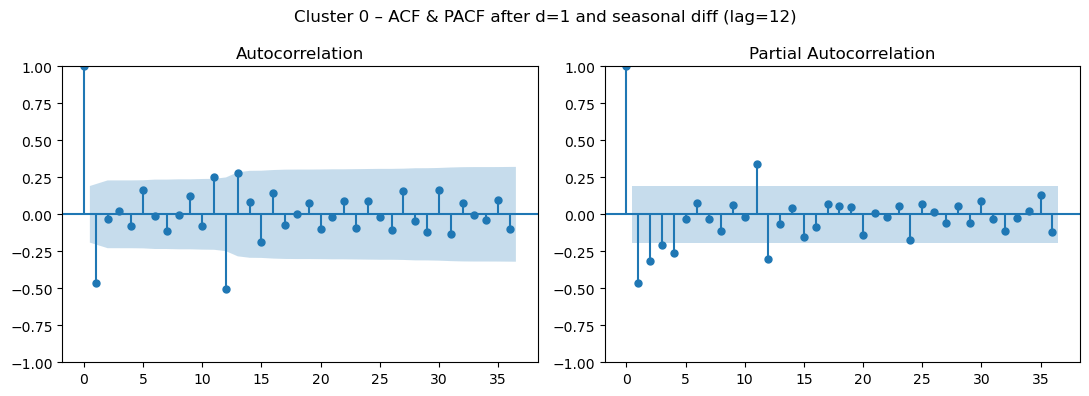

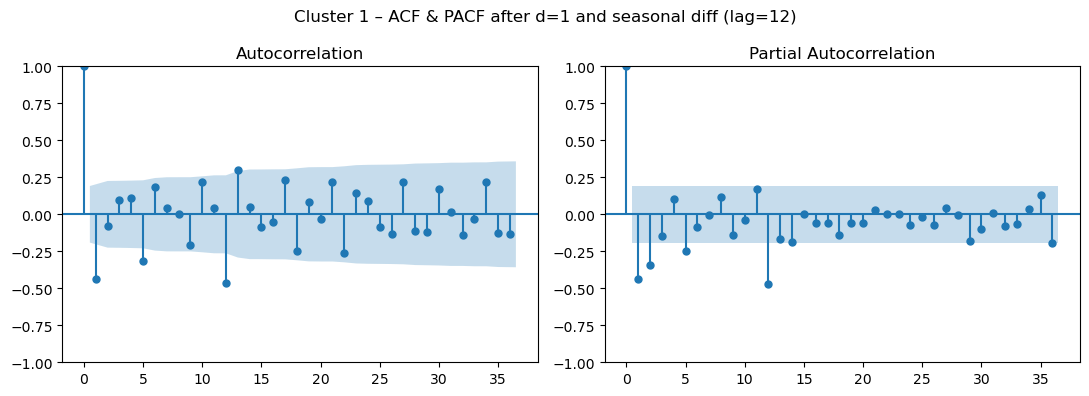

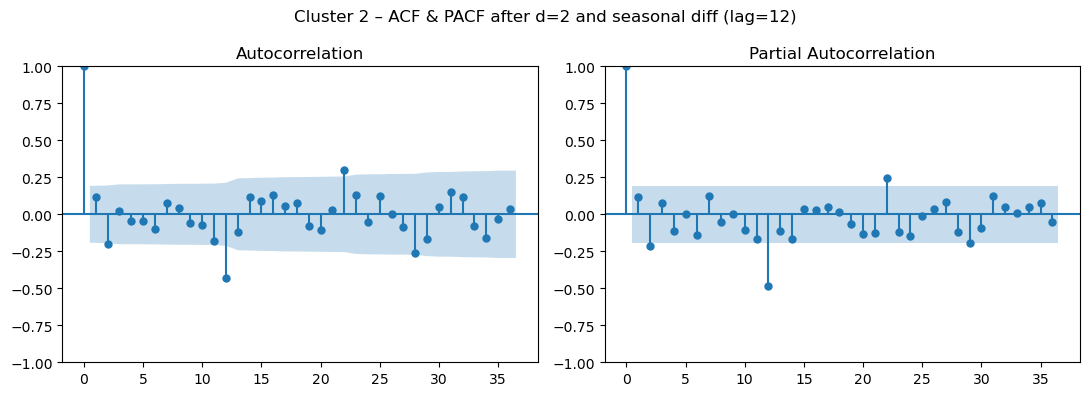

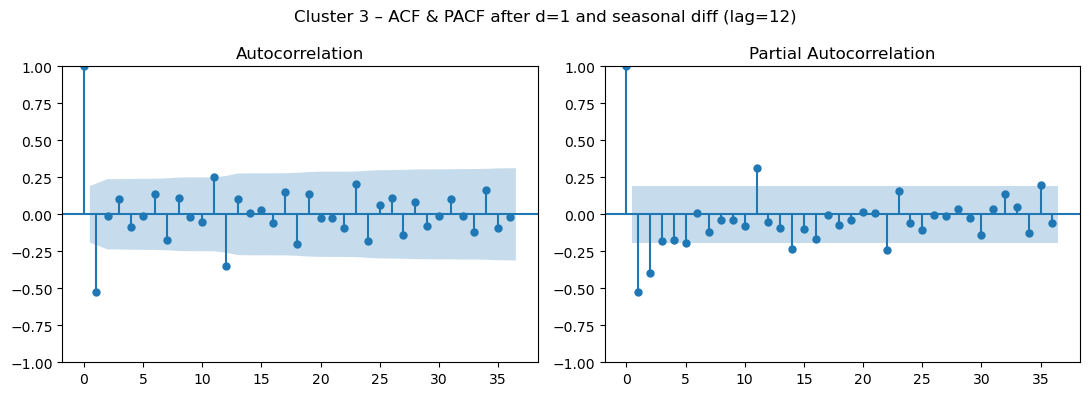

 Cluster  d  Seasonal_lag  ADF_p_final  KPSS_p_final  len_final_series
       0  1            12       0.0292        0.0417               105
       1  1            12       0.0000        0.1000               105
       2  2            12       0.0000        0.1000               104
       3  1            12       0.0052        0.1000               105


In [27]:
final_diff_store = {}   # keep for modeling later
final_stationarity = [] # optional summary table

for cid in sorted(cluster_monthly['Cluster'].unique()):
    # 1) monthly series
    ts = (cluster_monthly[cluster_monthly['Cluster']==cid]
          .set_index('date')['total_amount']
          .asfreq('ME')
          .fillna(0.0))

    # 2) pick non-seasonal d automatically (as you just did)
    d, _, _ = choose_d(ts, max_d=2, alpha=0.05)

    # 3) apply final transform: first non-seasonal diff (d), then seasonal diff (D=1, s=12)
    ts_d  = ts.diff(d) if d > 0 else ts.copy()
    ts_ds = ts_d.diff(SEASONAL_LAG).dropna()

    # 4) optional: confirm stationarity on the final series
    diag_final = _adf_kpss_flags(ts_ds, alpha=0.05)
    final_stationarity.append({
        "Cluster": cid,
        "d": d,
        "Seasonal_lag": SEASONAL_LAG,
        "ADF_p_final": diag_final['adf_p'],
        "KPSS_p_final": diag_final['kpss_p'],
        "len_final_series": len(ts_ds)
    })

    # 5) ACF/PACF plots on the *final* series that you'll feed to ARIMA
    plot_acf_pacf(ts_ds, f'Cluster {cid} – ACF & PACF after d={d} and seasonal diff (lag={SEASONAL_LAG})', lags=36)

    # 6) stash for ARIMA modeling
    final_diff_store[cid] = dict(series_final=ts_ds, d=d, seasonal_lag=SEASONAL_LAG)

# (optional) view final stationarity summary
final_stationarity_df = pd.DataFrame(final_stationarity).sort_values("Cluster")
print(final_stationarity_df.to_string(index=False))

### ARIMA

In [28]:
def mape(y_true, y_pred, eps=1e-8):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

In [29]:
def invert_seasonal_diff(forecast_sdiff, history_orig, s=12):
    history = list(history_orig)
    out = []
    for yhat_s in forecast_sdiff:
        base = history[-s]
        yhat = yhat_s + base
        out.append(yhat)
        history.append(yhat)
    return np.array(out)

In [39]:
def rolling_forecast_arima_with_outputs(ts, order, window=60, horizon=12, s=12):
    """
    Same as rolling_forecast_arima, but also returns preds, actuals, and their DateTimeIndex.
    """
    n = len(ts)
    if n < window + horizon + s:
        return dict(MAE=np.nan, RMSE=np.nan, MAPE=np.nan,
                    preds=np.array([]), actuals=np.array([]), index=pd.DatetimeIndex([]))

    preds, actuals, idx = [], [], []

    for start in range(0, n - window - horizon + 1):
        train = ts.iloc[start:start+window]
        test  = ts.iloc[start+window:start+window+horizon]

        train_sdiff = train.diff(s).dropna()
        if len(train_sdiff) < max(15, 2*sum(order)+1):
            continue

        try:
            model = ARIMA(train_sdiff, order=order,
                          enforce_stationarity=False, enforce_invertibility=False)
            res   = model.fit()
            fc_sdiff = res.forecast(steps=horizon)
        except Exception:
            continue

        preds_orig = invert_seasonal_diff(fc_sdiff, train.values, s=s)
        preds.extend(preds_orig)
        actuals.extend(test.values.astype(float))
        idx.extend(list(test.index))  # timestamps for these horizons

    if len(preds) == 0:
        return dict(MAE=np.nan, RMSE=np.nan, MAPE=np.nan,
                    preds=np.array([]), actuals=np.array([]), index=pd.DatetimeIndex([]))

    preds   = np.array(preds, dtype=float)
    actuals = np.array(actuals, dtype=float)
    index   = pd.DatetimeIndex(idx)

    mae  = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    mm   = mape(actuals, preds)

    return dict(MAE=mae, RMSE=rmse, MAPE=mm, preds=preds, actuals=actuals, index=index)


In [40]:
orders = {0:(1,1,0), 1:(0,1,1), 2:(0,1,0), 3:(1,1,0)}
results = []
for cid, order in orders.items():
    ts = (cluster_monthly[cluster_monthly['Cluster']==cid]
          .set_index('date')['total_amount'])
    res = rolling_forecast_arima(ts, order=order, window=60, horizon=12, s=12)
    results.append({'Cluster':cid, **res, 'Order':order})
    print(f"Cluster {cid}: ARIMA{order} → MAPE={res['MAPE']:.2f}, MAE={res['MAE']:.2f}, RMSE={res['RMSE']:.2f}")

results_df = pd.DataFrame(results)
print("\nPerformance summary:")
print(results_df.to_string(index=False))

Cluster 0: ARIMA(1, 1, 0) → MAPE=1.89, MAE=26150.29, RMSE=32682.48
Cluster 1: ARIMA(0, 1, 1) → MAPE=1.83, MAE=29532.15, RMSE=38234.16
Cluster 2: ARIMA(0, 1, 0) → MAPE=1.68, MAE=25603.03, RMSE=32144.43
Cluster 3: ARIMA(1, 1, 0) → MAPE=1.79, MAE=18644.69, RMSE=24431.46

Performance summary:
 Cluster         MAE        RMSE   MAPE     Order
       0 26,150.2902 32,682.4768 1.8855 (1, 1, 0)
       1 29,532.1521 38,234.1643 1.8344 (0, 1, 1)
       2 25,603.0323 32,144.4282 1.6816 (0, 1, 0)
       3 18,644.6912 24,431.4580 1.7939 (1, 1, 0)


In [44]:
def plot_final_window_forecast(ts, order, window=60, horizon=12, s=12, title_prefix="Cluster 2"):
    """
    Fit ARIMA on the last rolling window and plot its forecast vs actuals.
    """
    ts = ts.asfreq('ME').fillna(0.0)
    train = ts.iloc[-(window + horizon):-horizon]
    test  = ts.iloc[-horizon:]

    train_sdiff = train.diff(s).dropna()
    model = ARIMA(train_sdiff, order=order, enforce_stationarity=False, enforce_invertibility=False)
    res   = model.fit()
    fc_sdiff = res.forecast(steps=horizon)
    preds = invert_seasonal_diff(fc_sdiff, train.values, s=s)

    plt.figure(figsize=(10,4))
    plt.plot(ts.index, ts.values, label="Actual (full)", alpha=0.5, color="steelblue")
    plt.plot(test.index, test.values, label="Actual (test)", color="orange", linewidth=2)
    plt.plot(test.index, preds, label=f"ARIMA{order} forecast", color="green", linewidth=2)
    plt.title(f"{title_prefix} – Final Window Forecast (ARIMA{order})\n"
              f"Window={window} months, Horizon={horizon}")
    plt.xlabel("Month"); plt.ylabel("Total Amount ($)")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    print(f"MAPE={mape(test.values, preds):.2f}%, MAE={mean_absolute_error(test, preds):.0f}, RMSE={np.sqrt(mean_squared_error(test, preds)):.0f}")

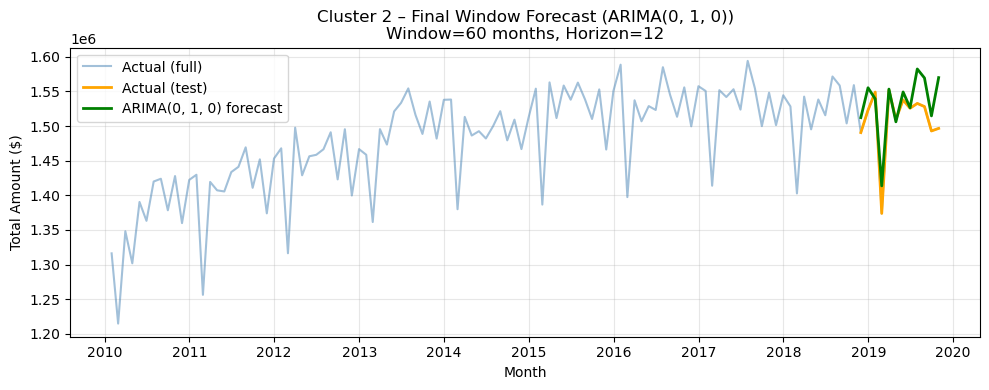

MAPE=1.71%, MAE=25543, RMSE=33340


In [45]:
plot_final_window_forecast(ts2, order=(0,1,0), window=60, horizon=12, s=12, title_prefix="Cluster 2")

In [46]:
def smooth_rolling_plot(out, ts, order, title_prefix="Cluster 2"):
    df = pd.DataFrame({'date': out['index'], 'actual': out['actuals'], 'pred': out['preds']})
    df = df.groupby('date', as_index=False).mean()
    plt.figure(figsize=(10,4))
    plt.plot(ts.index, ts.values, label="Actual (full)", alpha=0.4)
    plt.plot(df['date'], df['actual'], label="Actual (evaluated)", linewidth=2, color="orange")
    plt.plot(df['date'], df['pred'], label=f"ARIMA{order} (smoothed rolling)", linewidth=2, color="green")
    plt.title(f"{title_prefix} – Smoothed Rolling Forecast vs Actual (ARIMA{order})")
    plt.xlabel("Month"); plt.ylabel("Total Amount ($)")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

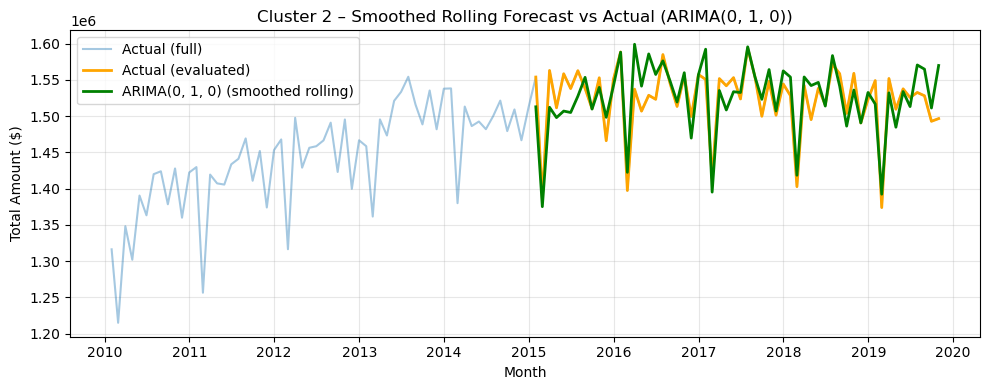

In [47]:
smooth_rolling_plot(res2, ts2, order=(0,1,0), title_prefix="Cluster 2")

In [48]:
def plot_all_rolling_windows(ts, order, window=60, horizon=12, s=12, max_plots=6):
    ts = ts.asfreq('ME').fillna(0.0)
    n = len(ts)
    windows = []
    for start in range(0, n - window - horizon + 1, horizon):  # jump by horizon
        train = ts.iloc[start:start+window]
        test  = ts.iloc[start+window:start+window+horizon]
        train_sdiff = train.diff(s).dropna()
        try:
            model = ARIMA(train_sdiff, order=order, enforce_stationarity=False, enforce_invertibility=False)
            res   = model.fit()
            fc_sdiff = res.forecast(steps=horizon)
            preds = invert_seasonal_diff(fc_sdiff, train.values, s=s)
            windows.append((train, test, preds))
        except:
            continue
        if len(windows) >= max_plots:  # limit so grid is not too crowded
            break

    n_plots = len(windows)
    fig, axes = plt.subplots(n_plots, 1, figsize=(9, 3*n_plots), sharex=True)
    if n_plots == 1:
        axes = [axes]

    for i, (train, test, preds) in enumerate(windows):
        ax = axes[i]
        ax.plot(train.index, train.values, label="Train", color="steelblue", alpha=0.6)
        ax.plot(test.index, test.values, label="Actual (test)", color="orange")
        ax.plot(test.index, preds, label="Forecast", color="green")
        ax.set_title(f"Rolling Window {i+1}: {train.index[0].strftime('%Y-%m')} → {test.index[-1].strftime('%Y-%m')}")
        ax.legend(); ax.grid(alpha=0.3)

    plt.suptitle(f"Cluster 2 – Rolling Window Forecasts (ARIMA{order})", y=0.99)
    plt.xlabel("Month"); plt.tight_layout(); plt.show()

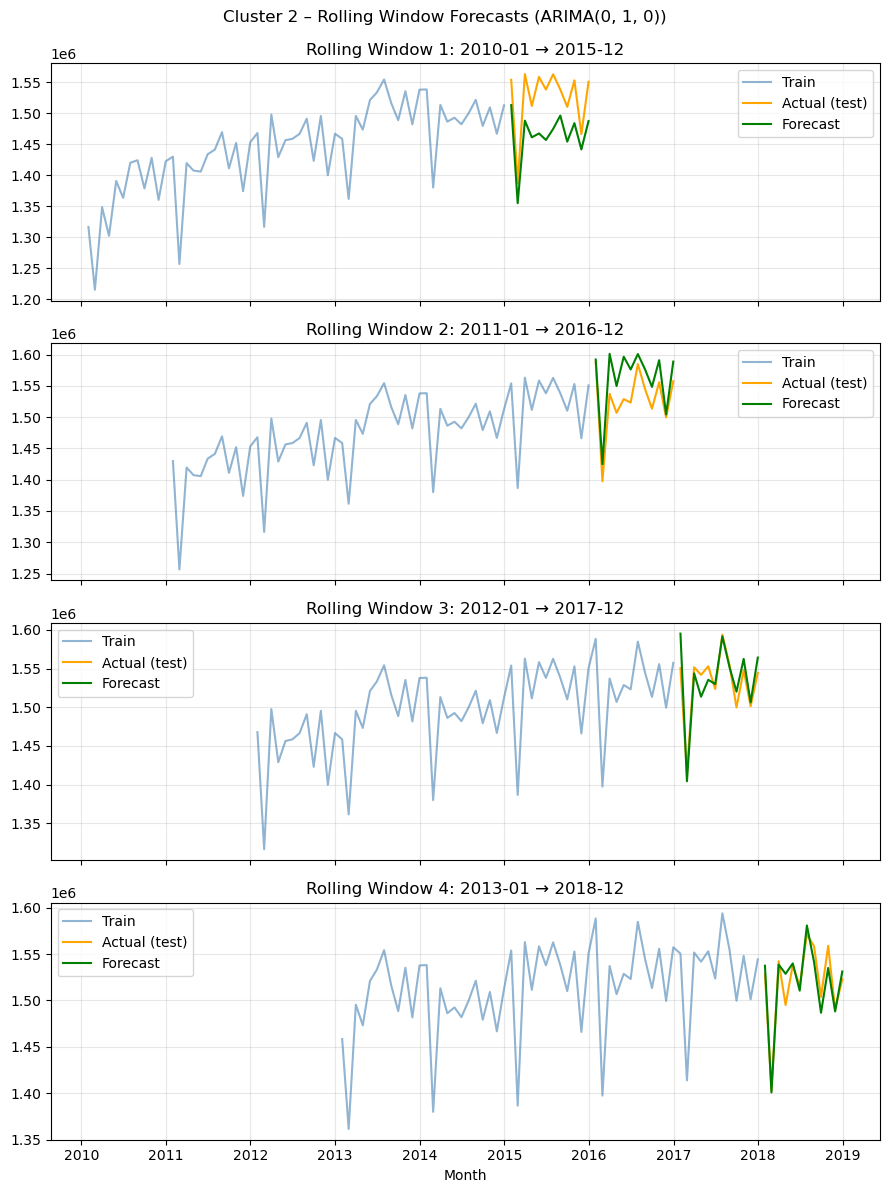

In [49]:
plot_all_rolling_windows(ts2, order=(0,1,0), window=60, horizon=12, s=12, max_plots=6)

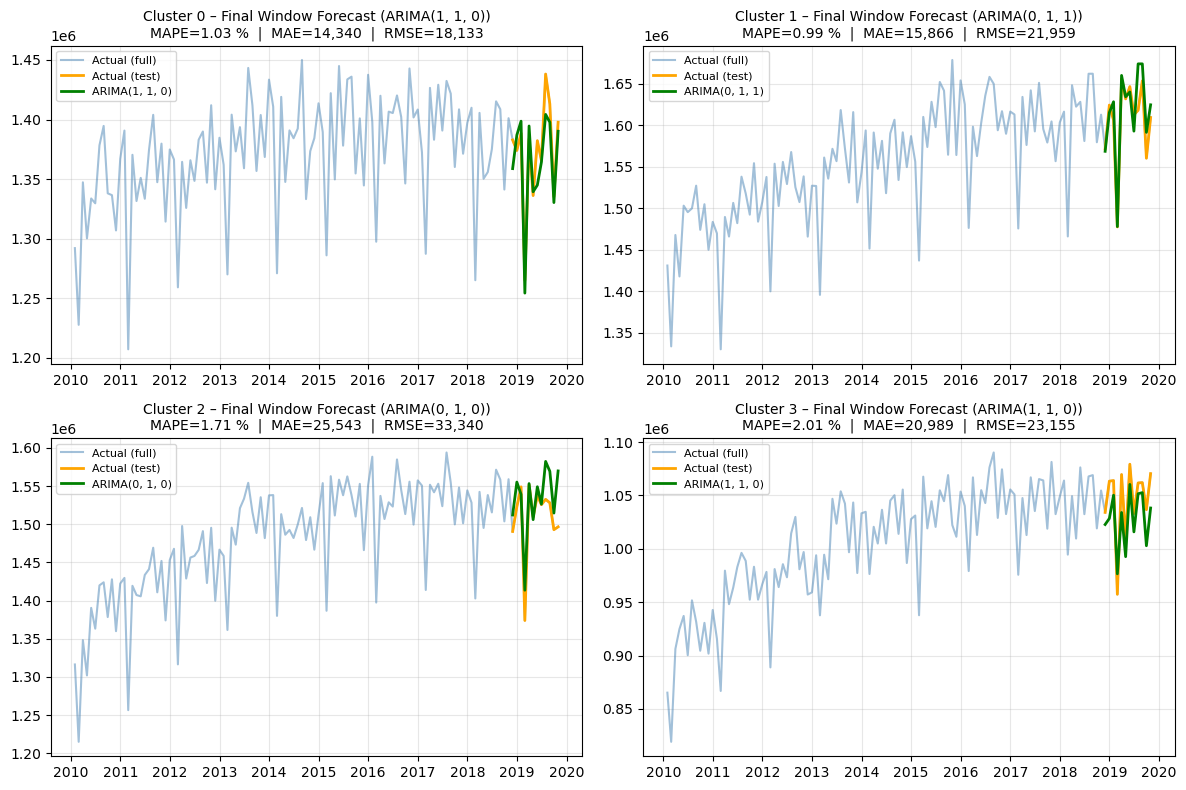

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def plot_final_window_forecast(ts, order, cluster_id, window=60, horizon=12, s=12):
    """Plot final rolling window forecast for one cluster."""
    ts = ts.asfreq('ME').fillna(0.0)
    train = ts.iloc[-(window + horizon):-horizon]
    test  = ts.iloc[-horizon:]

    train_sdiff = train.diff(s).dropna()
    model = ARIMA(train_sdiff, order=order, enforce_stationarity=False, enforce_invertibility=False)
    res   = model.fit()
    fc_sdiff = res.forecast(steps=horizon)
    preds = invert_seasonal_diff(fc_sdiff, train.values, s=s)

    mae  = mean_absolute_error(test, preds)
    rmse = np.sqrt(mean_squared_error(test, preds))
    mm   = mape(test, preds)

    plt.plot(ts.index, ts.values, label="Actual (full)", alpha=0.5, color="steelblue")
    plt.plot(test.index, test.values, label="Actual (test)", color="orange", linewidth=2)
    plt.plot(test.index, preds, label=f"ARIMA{order}", color="green", linewidth=2)
    plt.title(f"Cluster {cluster_id} – Final Window Forecast (ARIMA{order})\n"
              f"MAPE={mm:.2f} %  |  MAE={mae:,.0f}  |  RMSE={rmse:,.0f}",
              fontsize=10)
    plt.grid(alpha=0.3); plt.legend(fontsize=8)

# ---- cluster orders you finalized earlier ----
orders = {0:(1,1,0), 1:(0,1,1), 2:(0,1,0), 3:(1,1,0)}

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)
axes = axes.ravel()

for i, cid in enumerate(sorted(cluster_monthly['Cluster'].unique())):
    plt.sca(axes[i])
    ts = (cluster_monthly[cluster_monthly['Cluster']==cid]
          .set_index('date')['total_amount'])
    plot_final_window_forecast(ts, order=orders[cid], cluster_id=cid, window=60, horizon=12, s=12)

plt.tight_layout(); plt.show()


In [58]:
results_all = []

for cid, order in orders.items():
    ts = (cluster_monthly[cluster_monthly['Cluster']==cid]
          .set_index('date')['total_amount'])
    ts = ts.asfreq('ME').fillna(0.0)
    train = ts.iloc[-72:-12]   # 60 months train + 12 gap (optional)
    test  = ts.iloc[-12:]

    train_sdiff = train.diff(12).dropna()
    model = ARIMA(train_sdiff, order=order,
                  enforce_stationarity=False, enforce_invertibility=False)
    res   = model.fit()
    preds = invert_seasonal_diff(res.forecast(steps=12), train.values, s=12)

    mae  = mean_absolute_error(test, preds)
    rmse = np.sqrt(mean_squared_error(test, preds))
    mm   = mape(test, preds)

    results_all.append({
        "Cluster": cid, "Order": order,
        "MAPE (%)": round(mm, 2),
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "Mean Level": round(test.mean(), 2),
        "Rel MAE (%)": round(100 * mae / test.mean(), 2)
    })

comparison_df = pd.DataFrame(results_all)
print(comparison_df)

   Cluster      Order  MAPE (%)         MAE        RMSE     Mean Level  \
0        0  (1, 1, 0)    1.0300 14,340.0700 18,132.5400 1,371,878.1800   
1        1  (0, 1, 1)    0.9900 15,865.6400 21,958.7300 1,605,629.1600   
2        2  (0, 1, 0)    1.7100 25,543.0100 33,339.9600 1,509,243.9500   
3        3  (1, 1, 0)    2.0100 20,989.2600 23,154.9800 1,044,931.2700   

   Rel MAE (%)  
0       1.0500  
1       0.9900  
2       1.6900  
3       2.0100  


In [60]:
# 1. Baseline comparison
base = rolling_seasonal_naive(ts2, window=60, horizon=12, s=12)
print(f"Seasonal naive MAPE = {base['MAPE']:.2f}%")

# 2. Non-overlapping rolling (step=horizon)
res_nonoverlap = rolling_forecast_arima(ts2, order=(0,1,0), window=60, horizon=12, s=12)
print(f"Non-overlap MAPE = {res_nonoverlap['MAPE']:.2f}%")

# 3. 1-step-ahead version
res_1step = rolling_forecast_arima(ts2, order=(0,1,0), window=60, horizon=1, s=12)
print(f"1-step-ahead MAPE = {res_1step['MAPE']:.2f}%")

Seasonal naive MAPE = 1.63%
Non-overlap MAPE = 1.68%
1-step-ahead MAPE = 1.43%
